# Import Dependencies

In [10]:
# Dependencies
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Read Data File

In [11]:
# Data File
data = "../Resources/FINAL_CLEAN_FILE.csv"

# read to dataframe
data_df = pd.read_csv(data)
data_df.head()

,VAERS_ID,SYMPTOM,ASSIGNED_GROUP,SEVERITY_LEVEL,DIED,L_THREAT,HOSPITAL,AGE_YRS,AGE_GROUP,OTHER_MEDS,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,916600,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,33.0,26-35,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,917168,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,64.0,56-65,1.0,...,1.0,0,0,0,0,1,0,0,0,0
2,918386,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,62.0,56-65,1.0,...,1.0,0,0,0,0,1,0,0,0,0
3,918393,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,62.0,56-65,1.0,...,1.0,0,0,0,0,1,0,0,0,0
4,918479,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,37.0,36-45,1.0,...,1.0,0,0,1,0,0,0,0,0,0


In [12]:
severity = data_df['SEVERITY_LEVEL'].unique()
severity

array(['MILD', 'MODERATE', 'SEVERE'], dtype=object)

In [13]:
data_df.groupby(data_df['SEVERITY_LEVEL']).count()

,VAERS_ID,SYMPTOM,ASSIGNED_GROUP,DIED,L_THREAT,HOSPITAL,AGE_YRS,AGE_GROUP,OTHER_MEDS,CUR_ILL,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
SEVERITY_LEVEL,,,,,,,,,,,,,,,,,,,,,
MILD,23836,23836,23836,23836,23836,23836,23836,23836,23836,23836,...,23836,23836,23836,23836,23836,23836,23836,23836,23836,23836
MODERATE,1984,1984,1984,1984,1984,1984,1984,1984,1984,1984,...,1984,1984,1984,1984,1984,1984,1984,1984,1984,1984
SEVERE,662,662,662,662,662,662,662,662,662,662,...,662,662,662,662,662,662,662,662,662,662


In [14]:
data_df.columns

Index(['VAERS_ID', 'SYMPTOM', 'ASSIGNED_GROUP', 'SEVERITY_LEVEL', 'DIED',
       'L_THREAT', 'HOSPITAL', 'AGE_YRS', 'AGE_GROUP', 'OTHER_MEDS', 'CUR_ILL',
       'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA',
       'PFIZER', 'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', 'VAX_SITE_LA',
       'VAX_SITE_RA', '18-25', '26-35', '36-45', '46-55', '56-65', '66-75',
       '76-85', '86-95', '96 +'],
      dtype='object')

In [15]:
view_correlation = data_df[['VAERS_ID','SYMPTOM', 'ASSIGNED_GROUP', 'SEVERITY_LEVEL', 'HOSPITAL', 'AGE_YRS', 'AGE_GROUP', 'OTHER_MEDS',
                        'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA', 'PFIZER', 
                        'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', 'VAX_SITE_LA', 'VAX_SITE_RA']]

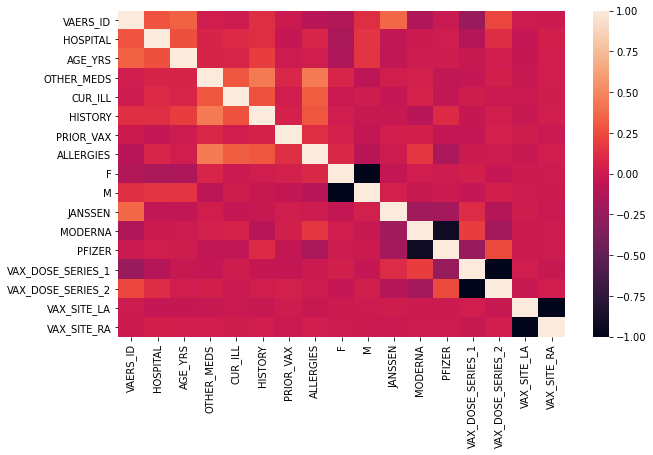

In [16]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(view_correlation.corr())
plt.show()

# Prep Data for Model

In [17]:
# Create Features by dropping columns we do not need (or already have in feature format)
X = data_df.drop(['VAERS_ID', 'SYMPTOM','ASSIGNED_GROUP','SEVERITY_LEVEL','HOSPITAL', 'DIED', 'L_THREAT', 'CUR_ILL', 'VAX_SITE_LA', 'VAX_SITE_RA', 'AGE_YRS', 'AGE_GROUP'], axis=1)
X

,OTHER_MEDS,HISTORY,PRIOR_VAX,ALLERGIES,F,M,JANSSEN,MODERNA,PFIZER,VAX_DOSE_SERIES_1,VAX_DOSE_SERIES_2,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0
1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0
4,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26477,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0
26478,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0
26479,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0
26480,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0


In [18]:
# Create Target (Severity Level column) and convert to numbers
y = LabelEncoder().fit_transform(data_df['SEVERITY_LEVEL'])
y

array([0, 0, 0, ..., 2, 1, 1])

In [19]:
# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Evaluate Model Function

In [21]:
def evaluate(pipeline, X_train, X_test, y_train, y_test):
    '''
    Evaluate a pipeline on training and test datasets
    '''    
    pipeline.fit(X_train, y_train)
    y_train_hat = pipeline.predict(X_train)
    y_test_hat = pipeline.predict(X_test)
    train_f1 = f1_score(y_train_hat, y_train,average='micro')
    train_acc = accuracy_score(y_train_hat, y_train)
    test_f1 = f1_score(y_test_hat, y_test, average='micro')
    test_acc = accuracy_score(y_test_hat, y_test)

    print(f"========== Predictor: {type(pipeline).__name__} ==========")
    print(f"Training result: f1: {train_f1:.3f}, acc: {train_acc:.3f}")
    print(f"Test result: f1: {test_f1:.3f}, acc: {test_acc:.3f}")
    print()

# Start with Logistic Regression

In [22]:
# try LogisticRegression to establish a baseline performance
model = LogisticRegression(max_iter=1000)
evaluate(model, X_train, X_test, y_train, y_test)

========== Predictor: LogisticRegression ==========
Training result: f1: 0.900, acc: 0.900
Test result: f1: 0.902, acc: 0.902



In [13]:
# try other predictors
evaluate(XGBClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(LGBMClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(RandomForestClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)

[16:08:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Samantha\anaconda3\envs\project4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


========== Predictor: XGBClassifier ==========
Training result: f1: 0.900, acc: 0.900
Test result: f1: 0.901, acc: 0.901

========== Predictor: LGBMClassifier ==========
Training result: f1: 0.900, acc: 0.900
Test result: f1: 0.901, acc: 0.901

========== Predictor: RandomForestClassifier ==========
Training result: f1: 0.901, acc: 0.901
Test result: f1: 0.899, acc: 0.899

========== Predictor: GradientBoostingClassifier ==========
Training result: f1: 0.900, acc: 0.900
Test result: f1: 0.902, acc: 0.902



# Save the Model

In [15]:
# save model
with open(f'../final_regression_model.sav', 'wb') as f:
    pickle.dump(model, f)
    

# User Input

In [23]:
# Define list of features and create empty user input list
features_np = ['OTHER_MEDS', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA', 'PFIZER',
       'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95',
       '96 +']
user_input = np.zeros(len(features_np))

In [24]:
# Raw User Input from user fields
age_group = '56-65'
sex = 'F'
other_meds = 1
history = 1
prior_vax = 1
allergies = 1
vax_name = 'PFIZER'
vax_dose = '2'

# Convert user input to list for model

age_idx = features_np.index(f'{age_group}')
sex_idx = features_np.index(f'{sex}')
vax_idx = features_np.index(f'{vax_name}')
dose_idx = features_np.index(f'VAX_DOSE_SERIES_{vax_dose}')

user_input[0] = other_meds
user_input[1] = history
user_input[2] = prior_vax
user_input[3] = allergies
user_input[sex_idx] = 1
user_input[vax_idx] = 1
user_input[dose_idx] = 1
user_input[age_idx] = 1


print(user_input)

[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [25]:
# Real Prediction
user_test = user_input
predicted_symptoms = model.predict([user_test])
print(predicted_symptoms)

[0]
